In [11]:
import numpy as np
import matplotlib.pyplot as plt
import quadrotor

In [12]:
dt = quadrotor.DELTA_T
m = quadrotor.MASS
g = quadrotor.GRAVITY
r = quadrotor.LENGTH
I = quadrotor.INERTIA

In [13]:
Q1 = np.diag([125,75,125,75,125,75])
Q2 = np.diag([3200,25,3000,25,4400,25])
R_ = (np.identity(2))*0.5
z_star = np.array([[3],[0],[3],[0],[(np.pi)/2], [0]])
u_star = np.array([[(m*g)/2], [(m*g)/2]])

In [14]:
def get_linearization(z,u):
  x = z[0]
  vx = z[1]
  y = z[2]
  vy = z[3]
  theta = z[4]
  omega = z[5]

  u1 = u[0]
  u2 = u[1]

  dfdx = np.array([[1,dt,0,0,0,0], [0,1,0,0,-(dt*(u1+u2)*np.cos(theta))/m,0], [0,0,1,dt,0,0],
                   [0,0,0,1,-(dt*(u1+u2)*np.sin(theta))/m,0], [0,0,0,0,1,dt], [0,0,0,0,0,1]])
  
  dfdu = np.array([[0,0], [(-dt*np.sin(theta))/m, (-dt*np.sin(theta))/m], [0,0],
                   [(dt*np.cos(theta))/m, (dt*np.cos(theta))/m], [0,0], [(dt*r/I), -(dt*r/I)]])
  
  A = dfdx
  B = dfdu

  return A,B

def get_A_B(xstar, ustar):
  A_list = []
  B_list = []
  for i in range(1000):
    A, B = get_linearization(xstar[:,i],ustar[:,i])
    A_list.append(A)
    B_list.append(B)
  return A_list, B_list

In [15]:
def compute_cost(z, u, horizon_length):
  cost = 0
  z_5 = np.array([[3.],[0.],[3.],[0.],[(np.pi)/2],[0.]])
  z_5 = z_5.reshape((6,1))
  u_des = np.array([[m*g/2],[m*g/2]])
  u_des = u_des.reshape((2,1))
  for n in range(horizon_length+1):
    if n>= 0 and n<=400:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn_T = zn.transpose()
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      cost = 0.5*(zn_T@Q1@zn + un_T@R_@un) + cost
    elif n>400 and n<=501:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      zn = zn-z_5
      zn_T = zn.transpose()
      cost = 0.5*(zn_T@Q2@zn + un_T@R_@un) + cost
    elif n>501 and n<1000:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn_T = zn.transpose()
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      cost = 0.5*(zn_T@Q1@zn + un_T@R_@un) + cost
    else:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn_T = zn.transpose()
      cost = 0.5*(zn_T@Q1@zn) + cost
  cost = cost[0][0]
  return cost

In [16]:
#get quadratic approximation cost
def get_quadratic_approximation_cost(z, u, horizon_length):
  r,q=[],[]
  Q,R=[],[]
  for i in range(horizon_length):
    if i<=400:
      q1=Q1@((z[:,i].reshape(6,1)))
      r1=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r1)
      q.append(q1)
      Q.append(Q1)
    
    elif i>400 and i<=501:
      q2=Q2@((z[:,i].reshape(6,1))-(z_star[:,0].reshape(6,1)))
      r2=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r2)
      q.append(q2)
      Q.append(Q2)
      
    else:
      q3=Q1@((z[:,i].reshape(6,1)))
      r3=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r3)
      q.append(q3)
      Q.append(Q1)
      
    R.append(R_)

  Q.append(Q1)
  q_l=-Q1@(z_star[:,0])
  q.append(q_l.reshape(6,1))
  
  
  return r,q,Q,R

In [17]:
def solve_LQR_trajectory(A_list, B_list, Q_list, R_list, q_list, r_list, N):
       
        P_1 = Q_list[N]
        p_1 = q_list[N]
        
        K_gains = []
        k_feedforward = []
        
        for i in range(N-1,-1,-1):
            
            #Added these since A and B are not same
            A = A_list[i]
            B = B_list[i]
            B_T = B.transpose()
            A_T = A.transpose()
        
            Q = Q_list[i]
            R = R_list[i]
            q = q_list[i]
            r = r_list[i]
            q = q.reshape((6,1))
            r = r.reshape((2,1))
            term = R + B_T@P_1@B
            inv_term = np.linalg.inv(term)

            Kn = -inv_term@B_T@P_1@A
            K_gains.insert(0,Kn)
            
            P = Q + A_T@P_1@A + A_T@P_1@B@Kn
            rn_term = B_T@p_1 + r
            kn = -inv_term@rn_term
            temp = kn.reshape((kn.shape[0],1))

            k_feedforward.insert(0, temp)
        
            p = q + A_T@p_1 + A_T@P_1@B@kn
            
            P_1 = P
            p_1 = p
        
        return K_gains, k_feedforward

In [18]:
def calculate_state(z_star,k_t,K_t,alpha,u_star_t,N):
  u_t=np.zeros([2,N])
  z_t=np.zeros([6,N+1])

  for n in range(N):
    u_o=u_star_t[:,n].reshape(2,1)+K_t[n].dot(z_t[:,n].reshape(6,1)-z_star[:,n].reshape(6,1))+alpha*k_t[n]
    z_t[:,n+1]= quadrotor.get_next_state(z_t[:,n],u_o)
    u_t[:,n]=u_o.reshape(2,)

  return z_t,u_t

In [19]:
#Iterative_LQR_loop
#Loop breaks when alpha is less than 0.1
#As per previous tests the solution is found before the loop breaks
horizon_length = 1000
ustar = np.zeros([2, horizon_length])
zstar = np.zeros([6, horizon_length+1])
alpha = 1

while True:
  for n in range(horizon_length):
    z_next = quadrotor.get_next_state(zstar[:,n],ustar[:,n])
    zstar[:,n+1] = z_next

  A_list,B_list = get_A_B(zstar,ustar)

  r_list,q_list,Q_list,R_list = get_quadratic_approximation_cost(zstar,ustar,horizon_length)
  
  K_gain,k_feedforward = solve_LQR_trajectory(A_list,B_list,Q_list,R_list,q_list,r_list,horizon_length)

  prev_cost = compute_cost(zstar,ustar,horizon_length)

  z_N,u_N = calculate_state(zstar,k_feedforward,K_gain,alpha,ustar,horizon_length)

  curr_cost = compute_cost(z_N,u_N,horizon_length)
  print("cost value is:", curr_cost)

  if curr_cost<prev_cost:
    prev_cost = curr_cost
  else:
    print("decreasing alpha")
    alpha = alpha/2
  
  ustar=u_N

  if alpha<0.1:
    break

cost value is: 3099594785.0076714
cost value is: 1036933.2280001902
cost value is: 1187767.10446601
decreasing alpha
cost value is: 438086.79271773493
cost value is: 275293.13803196914
cost value is: 224804.91412161337
cost value is: 209743.03789783342
cost value is: 205674.63116289314
cost value is: 204479.33178804856
cost value is: 204103.53714294612
cost value is: 203981.58985230932
cost value is: 203944.56733624914
cost value is: 203938.24182965627
cost value is: 203943.62984847874
decreasing alpha
cost value is: 203948.23274217165
decreasing alpha
cost value is: 203950.73803949507
decreasing alpha


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABUym1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA1jZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0b
M34HfeIBLw2NULVMqhzqmkC+X53Wgy7Lw2o5tSedGqtnOugH52lIi7P24behEG6Rnkk+WdTQf4eW
uPgCxivMZdxHEjn7VJLwZY+eI9HwO3plS7KgxBP2PAIULur9c1ztvyHTsIHpQ7AWk0MUEIPegRQe
mleg2OVFv447q+4/TWiy/+ZSzz1L5zehMVNsU5uy76TKZxI95ywPynYwwhdU/2fM2AnaYgwOfdkf
69A3REFLf6rK5fLs8TBpH4sqRqPKnDcIE+bSBngHwUCUcKJ4CnZV2Fc2GCOX6fHviA6j/zly2rMM
HUeiwnRJv2v0wCxmVpi0bb9R5cpW87efbtbkapNwAAADAACkO+cZ0stP/OH3eYLy91u40xzbOE20
ByD69s9+DABmn3QWsHL0mPtcVAIzZb7Vh3hwyFyO3O8PEAaWQTIy7/JSRilDyCxY9myTS2XjsHRr
cLZDzeBzHsYgZm1qK0pt5fPalV6EqlIAD4Nb74uRzyrU0QQ+shHMVOqZ2a4jMH+iG/s1HNTN7oNG
1fskfeaXj091zsRKRrFeX+LmnSVB8Bv/QuT0PhVVcA6zeJm8ZqTk+eNoBoluOyRQDTqH22p2lm1/
SjZ4oe1FcWSOeVSMN+4o06DECSjeyNYEOtk5lgUt8BXMYEapBdW/s0kxB2JPR6P3XiULFPFlt1+q
oRH6aHndVKuz43brCfMtXtD55d6r+n0TQAKlWrm5k6ywd4AzVe/zF6jmfcYCEggAAAMBawBz2N71
HqgtzgiF3JruEPq9thVHK3CrcUXF+w/UWorSk1yYuxQt0AKVJGioHNCM38+eYrFyTfSiqhhDTWCb
GWpFqvYqhKRZjv+spYjd35dzSfnQ+WM6ACshKLrxSGKCJFp/vEkxtFp+ZFVTE57Kf/0AGr7ZGhoa
2dE/70ZJVCVWjdPo33K6wwqB50p6/LnAiODhji8zOi159LcpOsO4SQwJ7Z6VUiynC1dUfAbICm/J
3FlJO7jz3hQRgrTdOFwqMUBN7IoK1rlElb1sVwSP7Lwf1ip6rpfh2XhA/hVksM7X5GarXjaJpqMo
ZEEroJ/JaHDS1xrDNKNe/0WsW8g+TqoAHQAAAwCCAVOMId42lge1abFYy66jPP4mzhlM8elDw8lK
Yc6WC7f/zVUlPShpjgBtNZ/6vc9WoIFJsE9VhCRDpfvmEQFQ+euOzuR/O2lrVGjbnGH6Ddg5OQFR
ev1m9fnPqA0ZRwDFO8g0YQ71aJ6SThVL1jdAOsmGYoEgyjVLcJqbW//y4P6gtPfizFQnFD6BVUv7
hhSGg8Ywm1Bs+NyvSUYWjPsztDjZu8R2vR/FJAYjd4PsUHuURjIGedzFEQXx6gp8u6sxzWWvE+z2
jtM2Kp2BrnB+9l1sklUvWAn7vP/ZKjOYDwW3aBmmfJI3Us9i1/hCx5yWCYl/W3gVKsELa01LSpnX
Qbm50SiNvufMAAADAEmALd0867lN4Ue8ipe1NOV6tdVFSzl29UfkZYeNRw5IBYRekM22S4fO/kb4
W0lV/+iYa/OW01Bj49l6m+p4/uplio5mL1QVvVYsRklQCxGvLOzSPK9p0wfvs8dTU/U28YirLWSa
YnKNWbV/6tyVJOzkRkufmKsyH1IEQEAcnLSj/ZawVTJLTecG9U6rGhnNvyBIBlTibPIlyR2DWDrT
Dhv+oAGN2ONTKmxgNoNpt2XH6Z1xbhVg6HPFC2t5zIeye22RNDhd4jrrJSsdDit1jt9Pj20VkjPW
8KaniIk/5F+rpkWHl+sztqWg7a0CKXFQgxlYwbllN75mwbS0caoe3K+/Irb4N1otqdswxX83wuyC
ESkV3MXfsdyw1fceKhJdAZQjp08BenHAnhzUYRxOwpceydhlE4hh9CmN9+Gh+dQV8hqBkosYXTE/
/dwSdNDA/qP9gBGI8bIWU1I6Lhs8bFmny60xhv5kwFz5QIw1x3l9Rh50jDtw4hpuABRuUdNMlS5l
VSi9VXV575vbOtr3zn/j+x6lOHXuCWsc7GyY391Dr+47BzWBf4gvR5hEXdB8ykNQKg/xLHsluoC4
5DixXSixDmDRwbdKh6E/DTGZS58S/sReSisJL+3om/a4fxwAALQAABwFZi+0DmQ5YjGezgeI8Lpf
Ohea++0NvFKoBUp+tMoyxrKNECu3spD6W5chZFepXubBHvf7Xv2bJ8KlYkWyse6pRqfOatuWbjtN
zBanjJ4/SkWA92Vs+2xFcdwRK+rXzhBS/ZNgvanuTAaz3gTNR6LIaOUTHpDwucFAPoj1Pi6FdSBv
D5VSf30pvvQBd//hAaEPHVebZXNhJRWE3ZjvNEmlzPZTJrBb+ED4Ze7EFLpPvC4+yYsbHSl/B1E5
u7NH42mLvVTy8lgyZJJxVvyKmNWPcfGximnmTZe3UsL+iGCjaFFrI653YpAWt6x1ipnLPtAs/9Cp
YCXfUDOySRJxZ0S1mknwRZCG/qZAsduLo0yWqAAAIjTK7ZS9a0fHyaoogeuwD36P88qCo3GjpXSw
fjI6Vm6uayqrZSGAFxRniQiNda+JZOzPE6S1PLkS0aT5e7SO5UzkJ1I2slsVkwD65nmmQW/uP6n+
FDq+uP8/KNYNrHZ2H/ozTCSIL+1rCYlOUq4r0PGCA7RcmxPTTzVw9AJ6KXX/+Gt4j3F35/TDLa8V
zrOc5eYemNPkf3afxpkvZ3OljKFWcb7+9Zn3wNmGtFC/fgoeqEqhINsiPoLJBAlROeiW7z2Lnhxe
eW/FLtIXs22HiP1r1YboIypjUXjTTGo0Bs3bUKqS8RyIyXk7nRIAAAMAAAUpAZQXiPb0Dc2VkiQS
ITVudTe2qiceOQw+7lObq

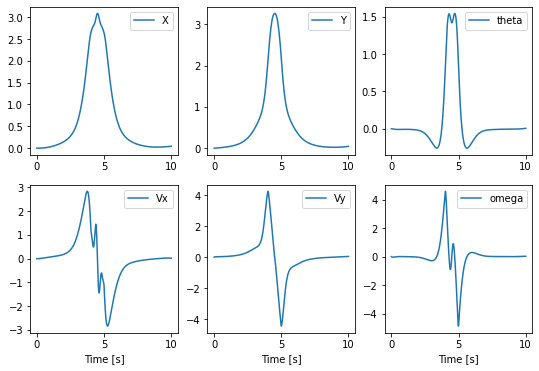

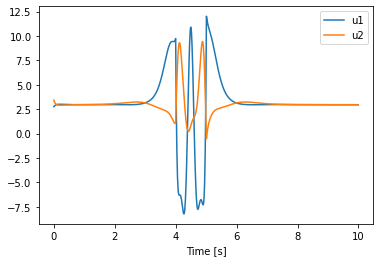

In [20]:
state = zstar
u = ustar
t = np.zeros([horizon_length+1,])
for i in range(horizon_length):
  t[i+1] = t[i] + dt

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# now we can also create an animation
quadrotor.animate_robot(state, u)